In [66]:
# !pip install shap

In [67]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [68]:
import os
# import shap
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modeling import FoldSet, GridSearch_ML, MLTest
from rnn_modeling import Make_DataSet
from visualization import Result_pred, Monthly_plot, Hourly_plot, TimeBar, Correlation

# Load data

In [69]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Train_Mp.csv')
print(df.shape)
df

(36663, 13)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Cloudy,Visibility,Time,Date,Area,Photovoltaics,Month
0,2.6,6.0,290.0,91.0,1019.6,0.0,10.0,1300.0,9,2013-01-01,전남 목포시,20.16,1
1,4.2,5.8,250.0,82.0,1019.9,0.7,7.0,1300.0,10,2013-01-01,전남 목포시,106.80,1
2,3.8,7.1,320.0,80.0,1020.5,0.7,9.0,1300.0,11,2013-01-01,전남 목포시,469.56,1
3,4.9,2.8,290.0,73.0,1020.1,0.7,7.0,1300.0,12,2013-01-01,전남 목포시,504.24,1
4,5.2,6.7,320.0,66.0,1019.7,0.8,6.0,1100.0,13,2013-01-01,전남 목포시,745.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36658,-0.2,5.9,360.0,79.0,1031.4,0.2,9.0,1206.0,14,2021-12-31,전남 목포시,312.00,12
36659,-0.7,5.0,360.0,83.0,1031.4,0.0,10.0,1040.0,15,2021-12-31,전남 목포시,163.80,12
36660,-0.6,5.1,360.0,83.0,1031.5,0.0,10.0,1057.0,16,2021-12-31,전남 목포시,103.44,12
36661,0.6,6.9,360.0,69.0,1031.1,0.0,9.0,2000.0,17,2021-12-31,전남 목포시,45.36,12


In [70]:
df['Date'].str[:4].unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021'], dtype=object)

In [71]:
df['Area'].unique()

array(['전남 목포시'], dtype=object)

# Create Deviation Variable

In [72]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time']]
cols

['Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Sunshine',
 'Cloudy',
 'Visibility',
 'Photovoltaics']

In [73]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32340, 8), (32340, 1) test: (4323, 8), (4323, 1)



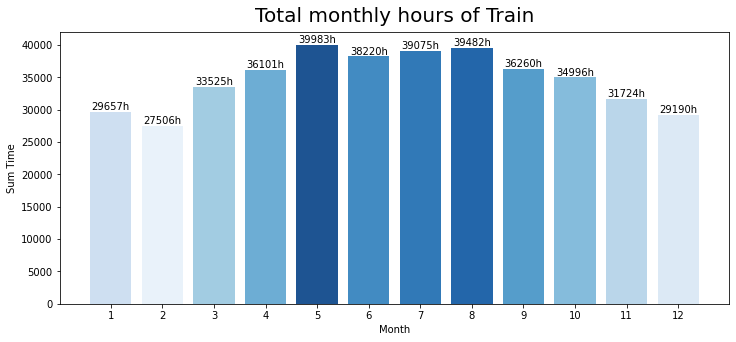

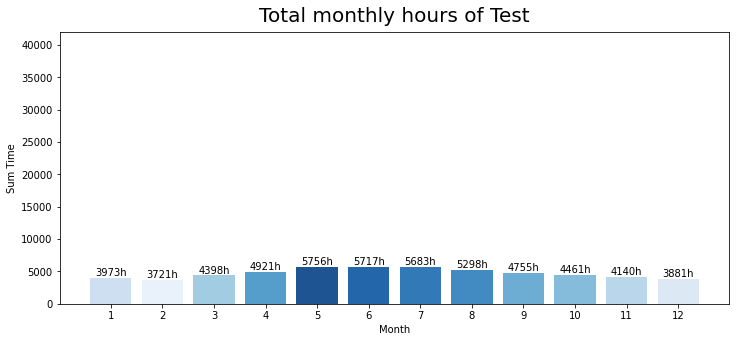

In [74]:
TimeBar(df.loc[:32340-1], 'Train', 42000)
TimeBar(df.loc[32340:], 'Test', 42000)

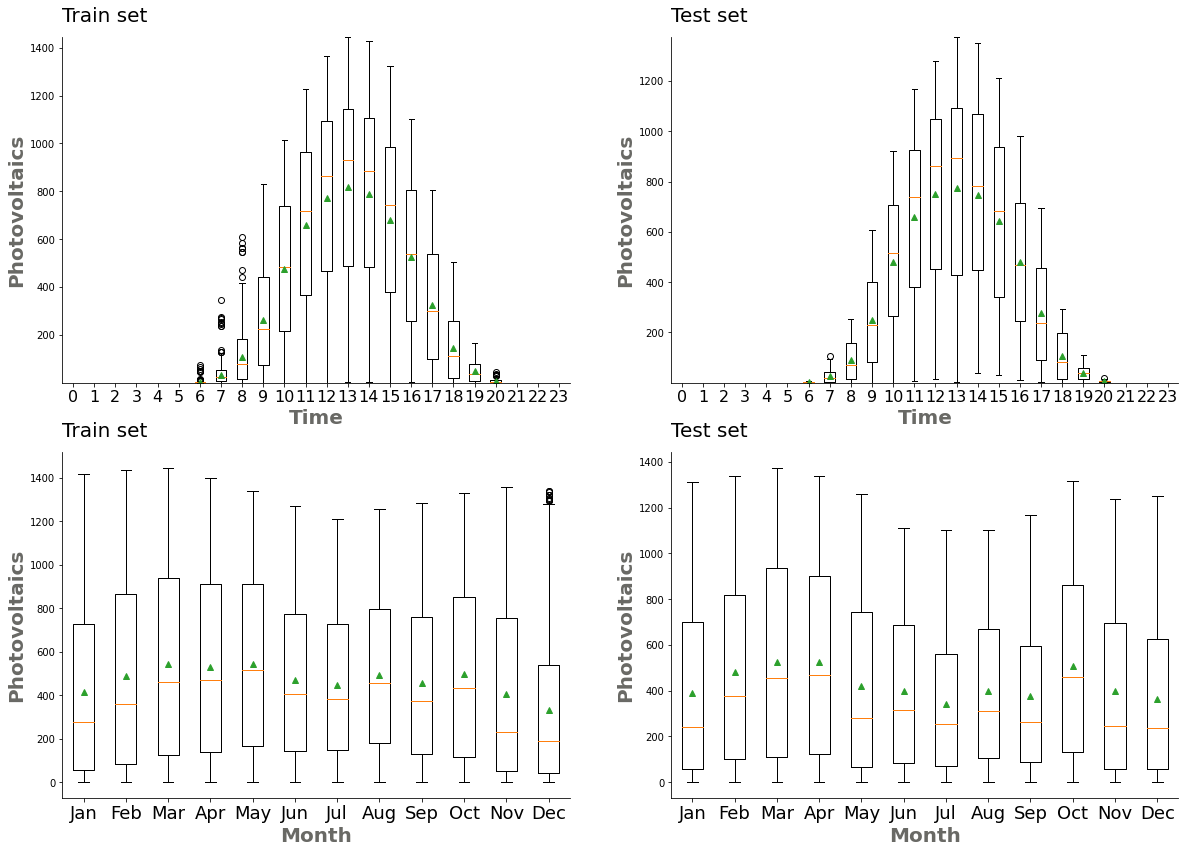

In [75]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
Hourly_plot(df.loc[:32340-1], 'Photovoltaics', ax1, 'Train set')
Monthly_plot(df.loc[:32340-1], 'Photovoltaics', ax3, 'Train set')
Hourly_plot(df.loc[32340:], 'Photovoltaics', ax2, 'Test set')
Monthly_plot(df.loc[32340:], 'Photovoltaics', ax4, 'Test set')

In [76]:
train_Mp = pd.concat([x_train, y_train], axis=1)
train_Mp

,dev_Temperature,dev_Wind velocity,dev_Wind direction,dev_Humidity,dev_Sea-level pressure,dev_Sunshine,dev_Cloudy,dev_Visibility,dev_Photovoltaics
0,2.061187,3.538813,148.584475,12.223744,-6.769406,-0.298174,4.515982,-13.689498,-25.226849
1,2.322477,2.841743,103.944954,7.486239,-6.639450,0.147248,1.894495,-32.559633,-138.406789
2,0.855455,3.554545,118.772727,9.463636,-5.927273,0.068182,4.086364,-92.918182,-40.891091
3,1.136406,-1.170046,63.824885,5.529954,-5.753456,0.021198,2.354839,-131.612903,-225.575115
4,0.643056,2.356019,76.805556,1.236111,-5.260185,0.109259,1.282407,-386.819444,-65.591111
...,...,...,...,...,...,...,...,...,...
32335,-7.918357,-3.842995,-65.507246,7.888889,1.023671,-0.308213,2.396135,387.942029,-402.318261
32336,-7.148058,2.729126,58.398058,22.635922,0.727184,-0.366019,3.305825,-1090.140777,-352.078835
32337,-6.998095,2.055714,77.619048,22.338095,0.784286,-0.341429,2.280952,383.938095,-36.441143
32338,-5.151659,2.723223,78.483412,5.085308,0.659242,-0.290995,2.246445,403.421801,2.674692


In [77]:
train_Mp.columns

Index(['dev_Temperature', 'dev_Wind velocity', 'dev_Wind direction',
       'dev_Humidity', 'dev_Sea-level pressure', 'dev_Sunshine', 'dev_Cloudy',
       'dev_Visibility', 'dev_Photovoltaics'],
      dtype='object')

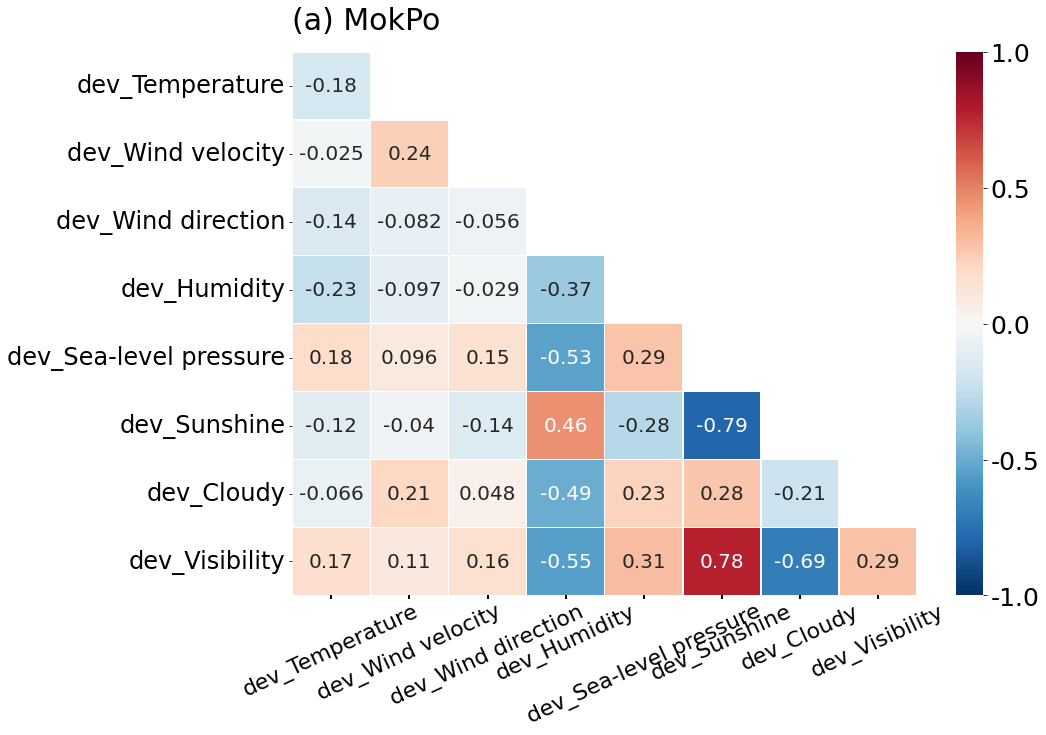

In [96]:
fig, ax1 =  plt.subplots(figsize=(14, 10))
ax1.set_title('(a) MokPo', loc='left', x=0, y=1.03, fontsize=30)
c = Correlation(train_Mp, train_Mp.columns, ax1)
fig.savefig('Mp_corr.png',  bbox_inches='tight', pad_inches=0, dpi=100)

# Fine-tuning the model

In [ ]:
params = {}

In [ ]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 4000, 'solver': 'adam'}
dev_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 35, 'objective': 'regression'}
ori_MLP {'activation': 'logistic', 'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}
ori_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}


# Model Learning

## LR 
(LinearRegression)

In [ ]:
# score점수 저장
score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

In [ ]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32340, 8), (32340, 1) test: (4323, 8), (4323, 1)

train: (5390, 8), (5390, 1) valid: (5390, 8), (5390, 1)

train: (10780, 8), (10780, 1) valid: (5390, 8), (5390, 1)

train: (16170, 8), (16170, 1) valid: (5390, 8), (5390, 1)

train: (21560, 8), (21560, 1) valid: (5390, 8), (5390, 1)

train: (26950, 8), (26950, 1) valid: (5390, 8), (5390, 1)

LinearRegression()


In [ ]:
ignore = MLTest(df, 'LR', params, score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (24806, 8), (24806, 1) test: (3475, 8), (3475, 1)

train: (4136, 8), (4136, 1) valid: (4134, 8), (4134, 1)

train: (8270, 8), (8270, 1) valid: (4134, 8), (4134, 1)

train: (12404, 8), (12404, 1) valid: (4134, 8), (4134, 1)

train: (16538, 8), (16538, 1) valid: (4134, 8), (4134, 1)

train: (20672, 8), (20672, 1) valid: (4134, 8), (4134, 1)

LinearRegression()


## MLP 
(MLPRegressor)

In [ ]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32340, 8), (32340, 1) test: (4323, 8), (4323, 1)

train: (5390, 8), (5390, 1) valid: (5390, 8), (5390, 1)

train: (10780, 8), (10780, 1) valid: (5390, 8), (5390, 1)

train: (16170, 8), (16170, 1) valid: (5390, 8), (5390, 1)

train: (21560, 8), (21560, 1) valid: (5390, 8), (5390, 1)

train: (26950, 8), (26950, 1) valid: (5390, 8), (5390, 1)

MLPRegressor(activation='logistic', learning_rate='adaptive', max_iter=4000)


In [ ]:
ignore = MLTest(df, 'MLP', params, score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32340, 8), (32340, 1) test: (4323, 8), (4323, 1)

train: (5390, 8), (5390, 1) valid: (5390, 8), (5390, 1)

train: (10780, 8), (10780, 1) valid: (5390, 8), (5390, 1)

train: (16170, 8), (16170, 1) valid: (5390, 8), (5390, 1)

train: (21560, 8), (21560, 1) valid: (5390, 8), (5390, 1)

train: (26950, 8), (26950, 1) valid: (5390, 8), (5390, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(400,), max_iter=3000)


## LGBM
 (LGBMRegressor)

In [ ]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32340, 8), (32340, 1) test: (4323, 8), (4323, 1)

train: (5390, 8), (5390, 1) valid: (5390, 8), (5390, 1)

train: (10780, 8), (10780, 1) valid: (5390, 8), (5390, 1)

train: (16170, 8), (16170, 1) valid: (5390, 8), (5390, 1)

train: (21560, 8), (21560, 1) valid: (5390, 8), (5390, 1)

train: (26950, 8), (26950, 1) valid: (5390, 8), (5390, 1)



In [ ]:
ignore = MLTest(df, 'LGBM', params, score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32340, 8), (32340, 1) test: (4323, 8), (4323, 1)

train: (5390, 8), (5390, 1) valid: (5390, 8), (5390, 1)

train: (10780, 8), (10780, 1) valid: (5390, 8), (5390, 1)

train: (16170, 8), (16170, 1) valid: (5390, 8), (5390, 1)

train: (21560, 8), (21560, 1) valid: (5390, 8), (5390, 1)

train: (26950, 8), (26950, 1) valid: (5390, 8), (5390, 1)



# Score

In [ ]:
score 

{'R2_dev_LR': 0.8135767106709164,
 'RMSE_dev_LR': 162.70849897706174,
 'R2_LR': 0.48936516383893636,
 'RMSE_LR': 269.28699198103453,
 'R2_dev_MLP': 0.8320065386714698,
 'RMSE_dev_MLP': 154.45655515047716,
 'R2_MLP': 0.5069682654543812,
 'RMSE_MLP': 264.6047233661302,
 'R2_dev_LGBM': 0.8317299613122457,
 'RMSE_dev_LGBM': 154.58364824532848,
 'R2_LGBM': 0.5625084271134074,
 'RMSE_LGBM': 249.25564416660774}

# Shap plot

In [ ]:
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  plt.title(f"{model_name} Shap plot", fontsize=15, pad=10)
  shap.summary_plot(shap_values, x_train, plot_size=0.4, plot_type='bar', show=True)
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=True)

Exact explainer: 32341it [05:01, 104.54it/s]                           


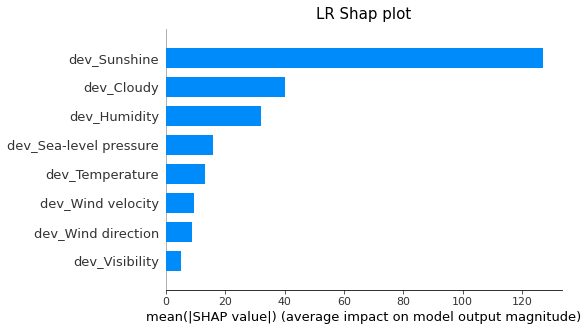

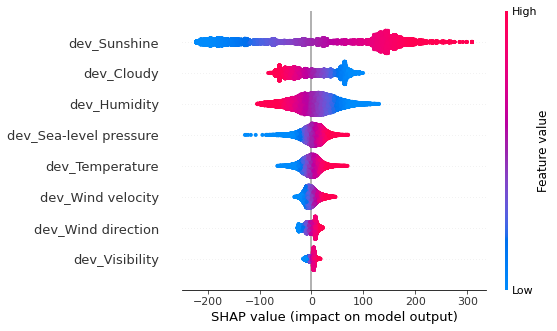

In [ ]:
ShapPlot(**Shap_dic['dev_LR'])

Exact explainer: 32341it [1:11:01,  7.57it/s]


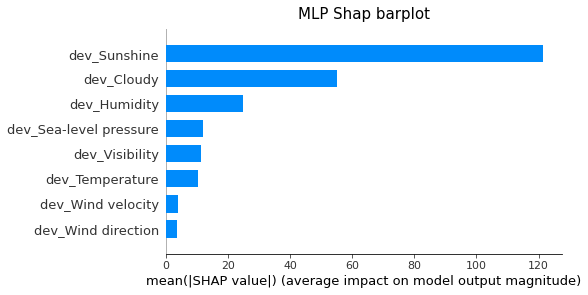

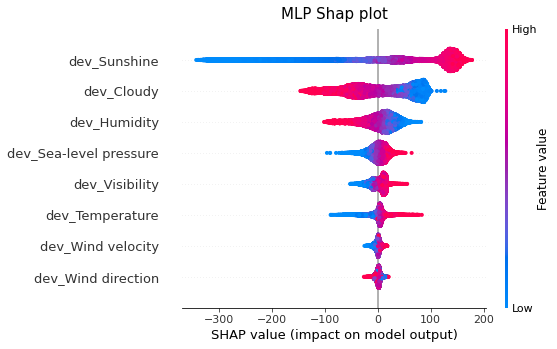

In [ ]:
ShapPlot(**Shap_dic['dev_MLP'])

Exact explainer: 32341it [1:22:22,  6.53it/s]


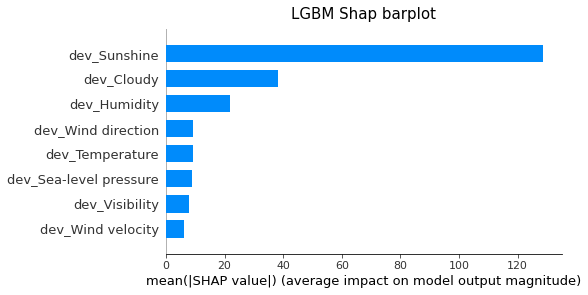

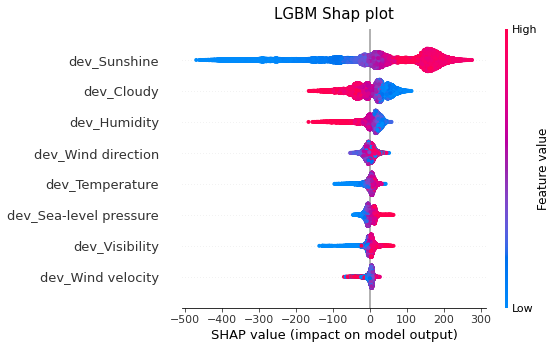

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

In [97]:
def Shap_feature(model, x_train, model_name, col1, col2):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)
  shap.plots.scatter(shap_values[:,col1], color=shap_values[:,col2])

Exact explainer: 32341it [1:04:46,  8.30it/s]


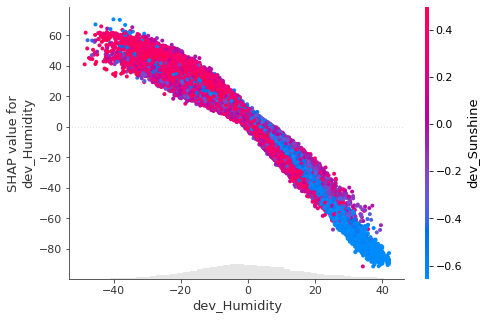

In [ ]:
Shap_feature(**Shap_dic['dev_MLP'], col1='dev_Humidity', col2='dev_Sunshine') 

Exact explainer: 32341it [46:47, 11.49it/s]                           


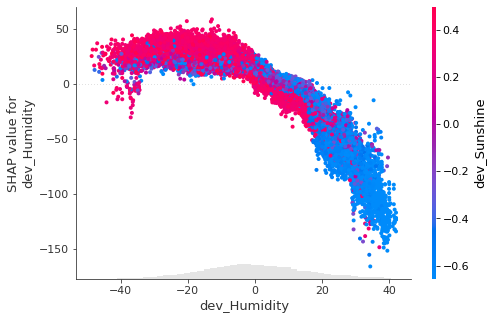

In [ ]:
Shap_feature(**Shap_dic['dev_LGBM'], col1='dev_Humidity', col2='dev_Sunshine') 

Exact explainer: 32341it [06:14, 83.87it/s]                           


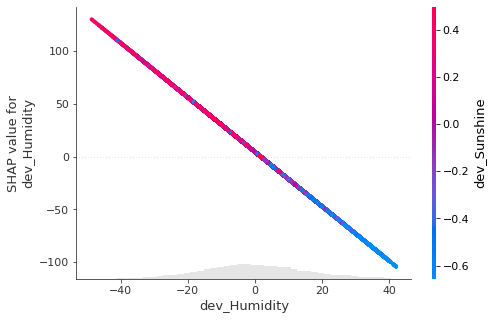

In [ ]:
Shap_feature(**Shap_dic['dev_LR'], col1='dev_Humidity', col2='dev_Sunshine')

# Result save

In [ ]:
data = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)
data

,Area,Date,Month,Time,Photovoltaics,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,전남 목포시,2021-01-01,1,9,25.20,18.674945,69.489768,43.164091,45.386849
1,전남 목포시,2021-01-01,1,10,323.28,262.240785,296.913521,277.444084,245.206789
2,전남 목포시,2021-01-01,1,11,564.00,421.173113,450.176082,475.697825,510.451091
3,전남 목포시,2021-01-01,1,12,442.44,562.975449,611.433359,622.315914,729.815115
4,전남 목포시,2021-01-01,1,13,563.88,683.896493,714.578010,730.485334,810.791111
...,...,...,...,...,...,...,...,...,...
4318,전남 목포시,2021-12-31,12,14,312.00,439.531636,501.409401,524.487243,670.158261
4319,전남 목포시,2021-12-31,12,15,163.80,56.885121,-52.980133,-77.085546,434.278835
4320,전남 목포시,2021-12-31,12,16,103.44,-77.223897,-136.245203,-103.455411,266.361143
4321,전남 목포시,2021-12-31,12,17,45.36,-162.397108,-201.101004,-181.579861,56.845308


In [ ]:
data.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)

In [ ]:
data.to_csv('/content/gdrive/MyDrive/SolarPower/Mokpo_pred.csv')